In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import coco_text

In [2]:
path = Path("synth-text-data/SynthText")
mat_file = path/'gt.mat'

import scipy.io
mat = scipy.io.loadmat(mat_file)

In [3]:
# ! wget "http://www.robots.ox.ac.uk/~vgg/data/scenetext/SynthText.zip"

In [4]:
def get_bboxes(img_id):
    if(img_id == 92): #corrup
        return []
    
    bboxes = mat['wordBB'][0][img_id]
    xs = bboxes[0].transpose()
    ys = bboxes[1].transpose()
    bbxs = []
    for i in range(0,len(xs)):
        ixs = xs[i]
        iys = ys[i]
        try:
            bbxs.append( [int(min(ixs)),int(min(iys)),int(max(ixs)-min(ixs)),int(max(iys)-min(iys))] )
        except:
            return []
            print(img_id + ' failed')
    return bbxs

In [5]:
# get_bboxes(93)

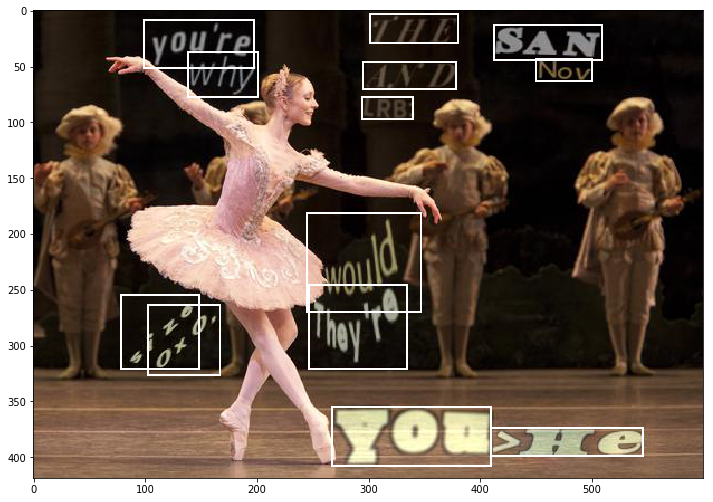

In [6]:
imageId = 94
img_name = mat['imnames'][0][imageId][0]
img = open_image(path/img_name)

fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(image2np(img.data))

bboxes = get_bboxes(imageId)
for bbox in bboxes:
    ax.add_patch(patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3], color='white', fill=False, lw=2))
ax

In [7]:
classes = {'text': 'text'}
annotations = []
images = []

# imgMetas = ct.loadImgs(ids=imgIds)
# annotIds = ct.getAnnIds(imgIds=imgIds)
# annotMetas = ct.loadAnns(annotIds)

for i, img in enumerate(mat['imnames'][0]):
    images.append( {'id': i, 'file_name': img[0]} )

for i, img in enumerate(mat['imnames'][0]):
    bboxes = get_bboxes(i)
    for bbox in bboxes:
        annotations.append({'bbox': bbox, 'image_id': i, 'category': 'text'})
    
annot_dict = {'annotations': annotations, 'images': images, 'classes': classes}

In [8]:
annot_dict['annotations'][0]

{'bbox': [420, 21, 92, 20], 'image_id': 0, 'category': 'text'}

In [9]:
def get_annotations(annot_dict, prefix=None):
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    
    classes = annot_dict['classes']
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[1],bb[0], bb[3]+bb[1], bb[2]+bb[0]])
        id2cats[o['image_id']].append(classes[o['category']])
    for o in annot_dict['images']:
        if o['id'] in id2bboxes:
#             print(o)
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]

In [10]:
images, lbl_bbox = get_annotations(annot_dict)
img2bbox = dict(zip(images, lbl_bbox))

In [20]:
images = [image[0] for image in mat['imnames'][0]]
img_df = pd.DataFrame(images, columns=['file_name'])
img_df.head()

,file_name
0,8/ballet_106_0.jpg
1,8/ballet_106_1.jpg
2,8/ballet_106_10.jpg
3,8/ballet_106_100.jpg
4,8/ballet_106_101.jpg


In [12]:
# img2bbox['8/ballet_106_83.jpg']

KeyError: '8/ballet_106_83.jpg'

In [ ]:
# import pickle
# with open('images.temp', 'wb') as temp_file:
#   pickle.dump(images, temp_file)
# with open('lbl_bbox.temp', 'wb') as temp_file:
#   pickle.dump(lbl_bbox, temp_file)

In [ ]:
# import pickle
# with open('images.temp', 'rb') as temp_file:
#     images = pickle.load(temp_file)
# with open('lbl_bbox.temp', 'rb') as temp_file:
#     lbl_bbox = pickle.load(temp_file)

In [23]:
def get_y_func(o):
    index = o.split('/')[-2]+"/"+o.split('/')[-1]
    if index in img2bbox:
        return img2bbox[index]
    else:
        return [[],[]]

In [24]:
annot_df = pd.DataFrame(lbl_bbox, columns=['bbox', 'classes'])
annot_df.head()

,bbox,classes
0,"[[21, 420, 41, 512], [46, 415, 68, 431], [47, ...","[text, text, text, text, text, text, text, tex..."
1,"[[231, 255, 299, 328], [14, 424, 32, 533], [39...","[text, text, text, text, text, text, text, tex..."
2,"[[47, 322, 74, 383], [352, 430, 397, 572], [19...","[text, text, text, text, text, text, text, tex..."
3,"[[213, 257, 294, 331], [6, 427, 30, 552], [37,...","[text, text, text, text, text, text, text, text]"
4,"[[200, 252, 253, 313], [269, 253, 318, 319], [...","[text, text, text, text, text, text, text, tex..."


In [25]:
# open_image('synth-text-data/SynthText/')

In [37]:
path = Path('/home/jupyter/coco')

data = (ObjectItemList.from_df(img_df, path, folder='synth-text-data/SynthText')
        #Where are the images? -> in coco
        .random_split_by_pct()                         
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(do_flip=False, flip_vert=False), size=300, tfm_y=True) #, do_crop=False, padding_mode='zeros')
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=20, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

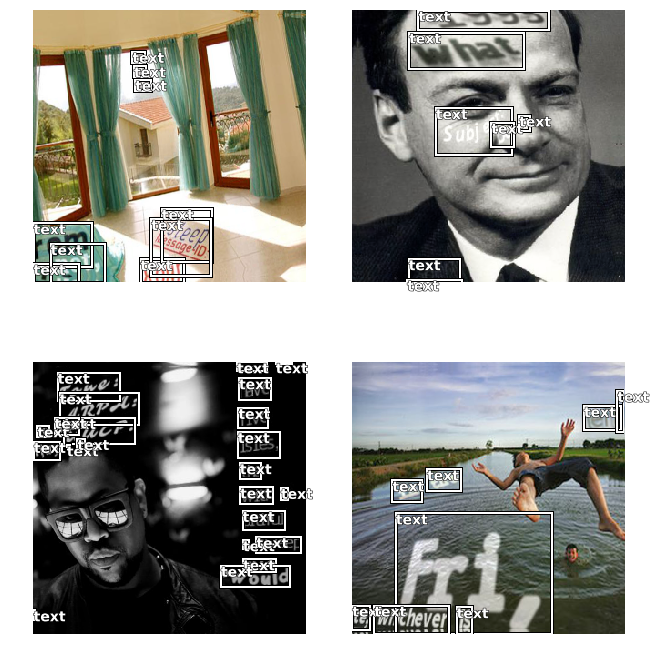

In [38]:
data.show_batch(2)

In [39]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, bn_final=True)

In [40]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate


ValueError: Target size (torch.Size([20, 23, 4])) must be the same as input size (torch.Size([20, 2]))